In [1]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# # Importing basic functions from other notebooks 
# import import_ipynb
# # from analyze_data_cleaned import *
# from analyze_data_cleaned import compute_symptoms_occurences_dataframe, plot_symptoms_occurences
# from analyze_data_cleaned import define_data_type
# from analyze_data_cleaned import apply_mask
# from analyze_data_cleaned import interesting_patients
# from analyze_data_cleaned import plot_accelerometer
# from analyze_data_cleaned import path_save_accelerometer_plots
# from analyze_data_cleaned import write_wav
# #from analyze_data_cleaned import remove_inactivity_pct_change


In [4]:
from create_graphs import *
from transform_data import *

# Which axis is more important? 

### CIS-PD 

In [ ]:
# Define the data type as we have two databases
data_type = "cis"
training_or_ancillary = 'training_data'
data_dir = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)

# NOTE: plot_axis_on_top only shows 10 first subject_id 
plot_axis_on_top(df_train_label, path_train_data, highpass=False)

### Visualisation with inactivity removed, after applying a highpass filter

In [ ]:
plot_axis_on_top(df_train_label, path_train_data, highpass=True)

### Analyze the kfold distribution V1

In [ ]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v1/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

In [ ]:
df_occurences, df_train_label_subject_id

### Analyze the kfold distribution V2

In [ ]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v2/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

# pids = np.array([1038])
pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

# CIS Database

## Distribution of the length of the files

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)
len_distribution = []
for idx in df_train_label.index:
        df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        len_distribution.append(len(df_train_data))


num_bins = 10
n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
plt.show()

print('min : ', min(len_distribution))
print('max : ', max(len_distribution))

### Remove activity with pct_change and plot the accelerometer after

measurement_id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


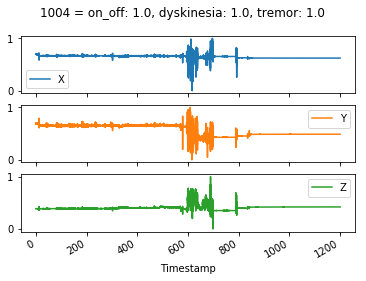

,X,Y,Z
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


len(filter_df)+periods  22159
len(df_train_data)  59805
Inactivity zones were detected  1  times out of  1
measurement_id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


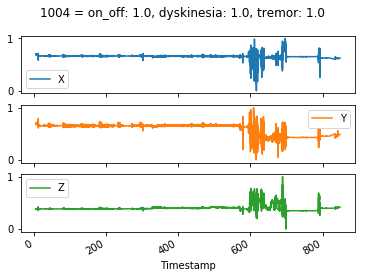

In [10]:
data_type = "cis"
data_dir = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
path_save_accelerometer_plots = "/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/"
training_or_ancillary='training_data'

path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

plot_accelerometer(df_train_label=df_train_label,
                   data_type=data_type,
                   path_train_data=path_train_data,
                   path_accelerometer_plots=path_save_accelerometer_plots)

path_no_inactivity_data = remove_inactivity_pct_change(df_train_label,
                                                       data_dir,
                                                       path_train_data,
                                                       data_type)

# Plot the accelerometer data
plot_accelerometer(df_train_label=df_train_label,
                   data_type=data_type,
                   path_train_data=path_train_data,
                   path_accelerometer_plots=path_save_accelerometer_plots,
                   path_inactivity=path_no_inactivity_data)

### How to print accelerometers before/after and write a wav file for 1 file 

In [ ]:
data_type = "cis"
path_save_accelerometer_plots = "/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/"
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)

list_measurement_id = ['db2e053a-0fb8-4206-891a-6f079fb14e3a']


df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Plot the accelerometer data
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots)

remove_inactivity_highpass(
    df_train_label,
    energy_threshold=10,
    duration_threshold=3000,
    plot_frequency_response=True,
    plot_accelerometer_after_removal=True,
    mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')


# Apply filter 
for idx in df_train_label.index:
    df_train_data = apply_mask(df_train_label["measurement_id"][idx],
                               mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')
    print('len : ', len(df_train_data))
    great_title = get_plot_title(idx, df_train_label)
    
    print('AFTER REMOVAL')
    #Plot accelerometer 
    print('len : ', len(df_train_data))
    x_axis_data_type = "t" if data_type == "real" else "Timestamp"
    df_train_data.plot(
                    x=x_axis_data_type, legend=True, subplots=True, title=great_title
                )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

# REAL-PD Database

path_train_labels :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/real-pd.data_labels/REAL-PD_Training_Data_IDs_Labels.csv
Nb subject_id :  1


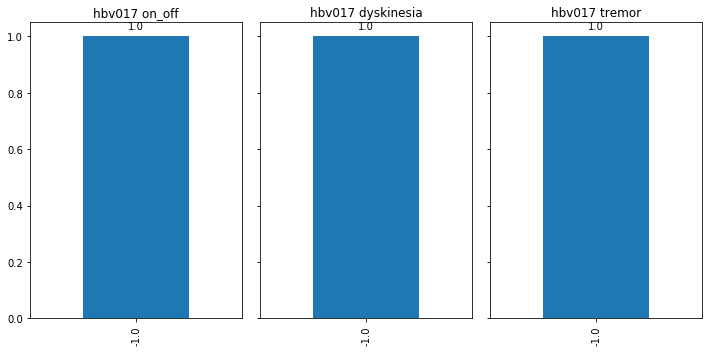

In [7]:
data_type = "real"
data_real_subtype = 'smartphone_accelerometer'
training_or_ancillary='training_data' #training_data
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)

list_measurement_id=['b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)


# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
    df_train_label=df_train_label
)

# Plot the graphs
plot_symptoms_occurences(
    df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
)

## Distribution of the length of the files

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "real"
training_or_ancillary='training_data'
data_real_subtype='smartphone_accelerometer'

for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary,
                                                   data_real_subtype)
    len_distribution = []

    for idx in df_train_label.index:
        try:
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
            len_distribution.append(len(df_train_data))
        except FileNotFoundError:
            continue
    print(data_real_subtype)
    num_bins = 10
    n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
    plt.show()
